In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def model_inputs(real_dim, z_dim):
    input_real = tf.placeholder(tf.float32, (None, real_dim))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    
    return input_real, input_z

# Generator Network

In [4]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    """
    z: input tensor for generator = random noise
    out_dim: shape of generator output
    n_units: number of units in hidden layer
    reuse: reuse the variables with tf.variable_scope
    alpha: leak parameter for leaky ReLu
    """
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

# Discriminator Network

In [5]:
def  discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

# Hyperparameters

In [6]:
input_size = 784
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smooth = 0.1

# Build Models

In [7]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Build the model
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
# g_model is the generator output

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

# Loss

In [8]:
# Loss
d_labels_fake = tf.zeros_like(d_logits_real) * (1 - smooth)
d_labels_real = tf.ones_like(d_logits_fake) 

d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels = d_labels_real, logits = d_logits_real)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels = d_labels_fake, logits = d_logits_fake)

d_loss = tf.reduce_mean(d_loss_fake + d_loss_real)

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(d_logits_fake), logits = d_logits_fake))

# Optimizer

In [9]:
learning_rate = 0.002
# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)


# Train
- epochs, batch_size, 
- when training the D, hold the values of G; when training the G, hold the values of D
- pretraining D before training G is recommended to get clearer gradient

In [10]:
batch_size = 100
epochs = 10
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/10... Discriminator Loss: 0.0221... Generator Loss: 4.5498
Epoch 2/10... Discriminator Loss: 0.0517... Generator Loss: 4.4570
Epoch 3/10... Discriminator Loss: 0.3407... Generator Loss: 3.5090
Epoch 4/10... Discriminator Loss: 0.8047... Generator Loss: 7.3341
Epoch 5/10... Discriminator Loss: 0.8626... Generator Loss: 3.7095
Epoch 6/10... Discriminator Loss: 1.1718... Generator Loss: 3.8423
Epoch 7/10... Discriminator Loss: 1.1732... Generator Loss: 1.6428
Epoch 8/10... Discriminator Loss: 1.3811... Generator Loss: 1.7474
Epoch 9/10... Discriminator Loss: 1.1872... Generator Loss: 1.4221
Epoch 10/10... Discriminator Loss: 1.1443... Generator Loss: 2.0543


# Train Loss

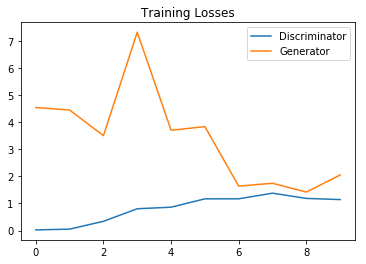

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Generator samples from training

In [14]:
def  view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [15]:

# Load samples from generator taken while training# Load  
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

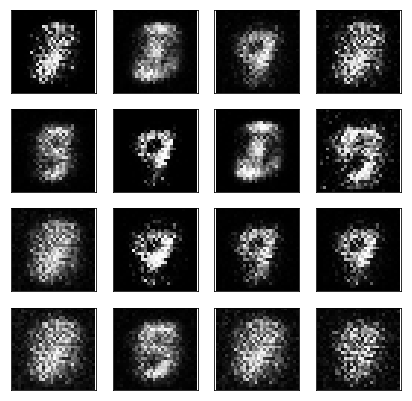

In [16]:
_ = view_samples(-1, samples)

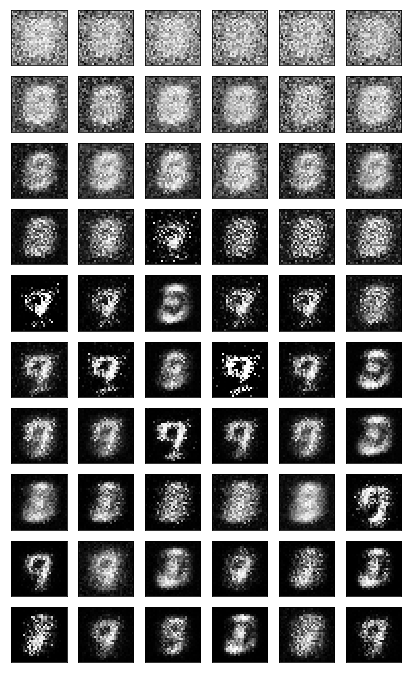

In [17]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


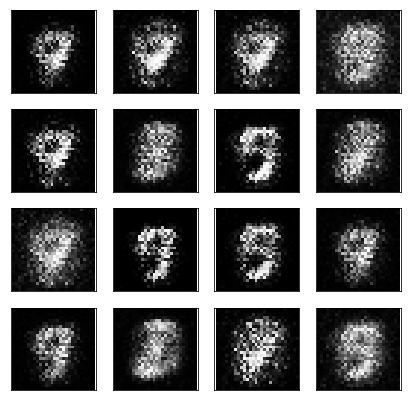

In [23]:
saver  ==  tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})
_ = view_samples(0, [gen_samples])